In [3]:
import pandas as pd
import os

# Define the root directory 

BASE_DIR = '/kaggle/input/dl-project/final-project-deep-learning-fall-2025/final_project_resources'

# Define paths to key resources
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
VAL_CSV_PATH = os.path.join(BASE_DIR, 'val.csv')
OFFSITE_TEST_CSV_PATH = os.path.join(BASE_DIR, 'offsite_test.csv')
IMAGE_DIR = os.path.join(BASE_DIR, 'images')

# Load the dataframes
train_df = pd.read_csv(TRAIN_CSV_PATH)
val_df = pd.read_csv(VAL_CSV_PATH)
offsite_test_df = pd.read_csv(OFFSITE_TEST_CSV_PATH)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Offsite Test samples: {len(offsite_test_df)}")

Train samples: 800
Validation samples: 200
Offsite Test samples: 200


## Data Exploration and Disease Distribution Visualization


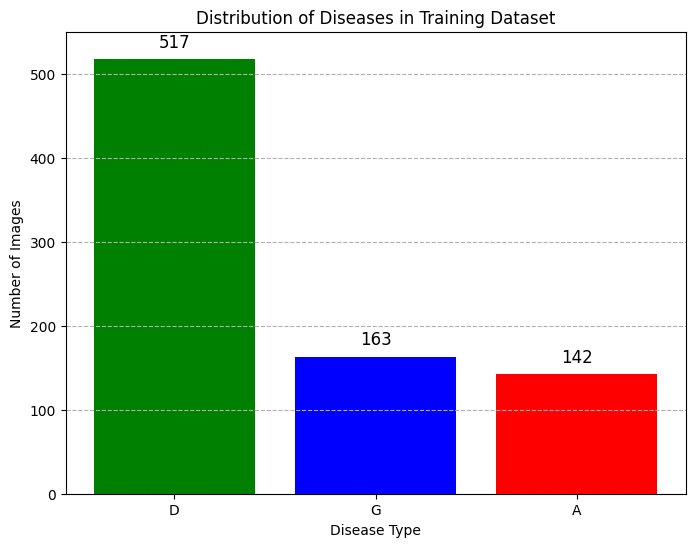

Disease distribution chart saved to: disease_distribution_train.png


In [4]:
import matplotlib.pyplot as plt

# Columns representing the three major diseases
DISEASE_COLUMNS = ['D', 'G', 'A']

# Calculate the count of each disease in the training set
disease_counts = train_df[DISEASE_COLUMNS].sum()

# --- Plotting the Distribution  ---
plt.figure(figsize=(8, 6))
bars = plt.bar(disease_counts.index, disease_counts.values, color=['green', 'blue', 'red'])

# Add the counts on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 10, int(yval), ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Diseases in Training Dataset')
plt.xlabel('Disease Type')
plt.ylabel('Number of Images')
plt.ylim(0, 550) # Set limit based on the document's visualization
plt.grid(axis='y', linestyle='--')

# Save the plot for the report 
CHART_PATH = 'disease_distribution_train.png'
plt.savefig(CHART_PATH)
plt.show()

print(f"Disease distribution chart saved to: {CHART_PATH}")
# Output will confirm the imbalance: D: 517, G: 163, A: 142 [cite: 50, 56, 57]

## Step 3: Implement Image Dataset and DataLoaders

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Define the image size (standardized to 256x256) 
IMG_SIZE = 256

class ODIRDataset(Dataset):
    def __init__(self, df, image_dir, mode='train'):
        self.df = df
        self.image_dir = image_dir
        self.mode = mode

        # Logic to match the folder structure in the resources [cite: 108]
        if mode == 'train':
            self.image_folder = os.path.join(image_dir, 'train')
        elif mode == 'val':
            self.image_folder = os.path.join(image_dir, 'val')
        elif mode == 'test':
            self.image_folder = os.path.join(image_dir, 'offsite_test') 
        elif mode == 'test_onsite': # Added this to fix the AttributeError
            self.image_folder = os.path.join(image_dir, 'onsite_test')
        else:
            raise ValueError(f"Unknown mode: {mode}")

        self.transform = self._get_transforms(mode)

    def _get_transforms(self, mode):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            normalize
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['id']
        image_path = os.path.join(self.image_folder, image_id)

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        
        # Use ['D', 'G', 'A'] for consistency with the submission template [cite: 112]
        if self.mode != 'test_onsite': 
            labels = torch.tensor(row[DISEASE_COLUMNS].values.astype(float), dtype=torch.float32)
            return image, labels
        else:
            return image, image_id

# Example DataLoaders
train_dataset = ODIRDataset(train_df, IMAGE_DIR, mode='train')
val_dataset = ODIRDataset(val_df, IMAGE_DIR, mode='val')
offsite_test_dataset = ODIRDataset(offsite_test_df, IMAGE_DIR, mode='test')

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
offsite_test_loader = DataLoader(offsite_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# generate the onsite_submission_task1.csv file
generate_onsite_submission(model_eff_1_3, DEVICE, 'onsite_submission_task1.csv')

Submission saved to onsite_submission_task1.csv. for uploading to kaggle


# Phase 2: Task 1: Transfer Learning Implementation

## Step 4: Model and Core Functions Setup

In [6]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support

# --- A. Model Definition ---
class TransferModel(nn.Module):
    def __init__(self, backbone, num_classes=3):
        super().__init__()
        self.backbone = backbone
        in_features = 0
        
        # --- Logic to handle different backbone structures ---
        if hasattr(self.backbone, 'fc'):
            # This handles ResNet
            in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity() # Remove original head
        elif hasattr(self.backbone, 'classifier'):
            # This handles EfficientNet (whose classifier is a sequential block)
            # The last layer [1] in the sequential block is the final Linear layer
            in_features = self.backbone.classifier[1].in_features
            self.backbone.classifier = nn.Identity() # Remove original head
        else:
            raise AttributeError("Backbone model structure not recognized. Cannot find 'fc' or 'classifier' attribute.")


        # New classification head for 3 diseases (multi-label)
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes) # Outputs logits for D, G, A
        )

    def forward(self, x):
        # The output of nn.Identity() is still in a 4D tensor form (batch, channels, 1, 1) 
        # or similar after global pooling, so we need to flatten it.
        features = self.backbone(x)
        return self.classifier(features.view(features.size(0), -1))

# --- B. Evaluation Function (Save Metrics) ---
def evaluate_and_save_metrics(model, data_loader, device, task_name, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Apply sigmoid for multi-label classification and threshold at 0.5
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate metrics for each class (D, G, A)
    precision, recall, fscore, _ = precision_recall_fscore_support(
        all_labels, all_preds, average=None, zero_division=0, labels=[0, 1, 2]
    )
    
    # Calculate average F-score over the three diseases 
    avg_fscore = fscore.mean()

    # Create a DataFrame to store and save the results (CRUCIAL CHECKPOINTING STEP)
    metrics_df = pd.DataFrame({
        'Task': [task_name] * 3,
        'Model': [model_name] * 3,
        'Disease': DISEASE_COLUMNS,
        'Precision': precision,
        'Recall': recall,
        'F-score': fscore
    })
    metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]

    # Save the metrics to a running CSV file
    FILE_NAME = 'task1_offsite_test_metrics.csv'
    if os.path.exists(FILE_NAME):
        metrics_df.to_csv(FILE_NAME, mode='a', header=False, index=False)
    else:
        metrics_df.to_csv(FILE_NAME, index=False)

    print(f"\n--- {task_name} Metrics ---")
    print(f"Average F-score: {avg_fscore:.4f}")
    print(metrics_df)
    
    return avg_fscore

# Define device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


Step 5: Implement Task 1.1: No Fine-Tuning (Evaluation Only)


In [7]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_b0, resnet18 

# Define device 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR = '/kaggle/input/dl-project/final-project-deep-learning-fall-2025/final_project_resources' 

# --- MODEL LOADING FUNCTION ---
def load_backbone_only(model, checkpoint_path, device):
    """
    Loads weights from a checkpoint, explicitly removing classifier keys 
    to prevent size mismatch errors when the model structure changes.
    """
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # 1. Inspect and remove mismatched keys from the checkpoint
    mismatched_keys = []
    
    # Checkpoint structure differs slightly for EfficientNet vs ResNet
    if 'EfficientNet' in str(type(model)):
        # Keys for EfficientNet classifier that cause the mismatch (classifier.1 is a Linear layer)
        mismatched_keys.extend(['classifier.1.weight', 'classifier.1.bias']) 
    elif 'ResNet' in str(type(model)):
        # Keys for ResNet classifier (fc is the final fully connected layer)
        mismatched_keys.extend(['fc.weight', 'fc.bias']) 
        
    for key in mismatched_keys:
        if key in checkpoint:
            del checkpoint[key]
            # print(f"Removed mismatched key: {key}") # Debugging aid

    # 2. Load the state dictionary with strict=False (as a fallback, but the removal is key)
    # PyTorch will ignore any remaining keys that are not found in the target model.
    model.load_state_dict(checkpoint, strict=False)
    model = model.to(device)
    return model

In [8]:
# --- A. EfficientNet ---
eff_checkpoint_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_efficientnet_ep50.pt')

# 1. Load the pre-trained backbone structure (default 1000 classes)
eff_backbone = efficientnet_b0(weights=None) 

# 2. Load the project's specific pre-trained weights (only backbone part)
eff_backbone = load_backbone_only(eff_backbone, eff_checkpoint_path, DEVICE)

# 3. Create the full model 
model_eff = TransferModel(eff_backbone).to(DEVICE) 

# 4. Evaluation 
evaluate_and_save_metrics(model_eff, offsite_test_loader, DEVICE, 'Task 1.1: No Fine-tuning', 'EfficientNet')

# --- B. ResNet18 ---
res_checkpoint_path = os.path.join(BASE_DIR, 'pretrained_backbone/ckpt_resnet18_ep50.pt')

# 1. Load the pre-trained backbone structure
res_backbone = resnet18(weights=None) 

# 2. Load the project's specific pre-trained weights (only backbone part)
res_backbone = load_backbone_only(res_backbone, res_checkpoint_path, DEVICE)

# 3. Create the full model
model_res = TransferModel(res_backbone).to(DEVICE)

# 4. Evaluation
evaluate_and_save_metrics(model_res, offsite_test_loader, DEVICE, 'Task 1.1: No Fine-tuning', 'ResNet18')

/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.1: No Fine-tuning Metrics ---
Average F-score: 0.4323
                       Task         Model  Disease  Precision    Recall  \
0  Task 1.1: No Fine-tuning  EfficientNet        D   0.725926  0.700000   
1  Task 1.1: No Fine-tuning  EfficientNet        G   0.245000  1.000000   
2  Task 1.1: No Fine-tuning  EfficientNet        A   0.115385  0.545455   
3  Task 1.1: No Fine-tuning  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.712727  
1  0.393574  
2  0.190476  
3  0.432259  

--- Task 1.1: No Fine-tuning Metrics ---
Average F-score: 0.0711
                       Task     Model  Disease  Precision    Recall   F-score
0  Task 1.1: No Fine-tuning  ResNet18        D   0.500000  0.007143  0.014085
1  Task 1.1: No Fine-tuning  ResNet18        G   0.000000  0.000000  0.000000
2  Task 1.1: No Fine-tuning  ResNet18        A   0.110553  1.000000  0.199095
3  Task 1.1: No Fine-tuning  ResNet18  Average        NaN       NaN  0.071060


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0.07105984322222932

## Task 1.2: Frozen Backbone, Fine-Tune Classifier Only

In [9]:
import torch.optim as optim
import torch.nn as nn
import time

def train_classifier_only(model, train_loader, val_loader, device, model_name, task_name, num_epochs=10, lr=1e-3):
    """Trains only the classification head of the model."""
    
    print(f"\n--- Starting Training for {task_name} ({model_name}) ---")
    
    # 1. Freeze the Backbone (Crucial step for Task 1.2)
    for param in model.backbone.parameters():
        param.requires_grad = False
        
    # 2. Target Only the Classifier for Optimization
    # The new classifier head's parameters still have requires_grad=True by default.
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss() 
    
    best_fscore = 0.0
    model_checkpoint_path = f'teamDL_{model_name}_task1.2_best.pt'
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        # --- Training ---
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # --- Validation and Checkpointing ---
        # Evaluate on the validation set to decide if this is the best model
        val_fscore = evaluate_and_save_metrics(
            model, 
            val_loader, 
            device, 
            f'{task_name} (Val Epoch {epoch})', 
            model_name
        )
        
        # Save the best model based on validation F-score (CRUCIAL CHECKPOINTING)
        if val_fscore > best_fscore:
            best_fscore = val_fscore
            torch.save(model.state_dict(), model_checkpoint_path)
            print(f"-> Checkpoint saved! Best Val F-score: {best_fscore:.4f}")
        
        print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f} - Time: {time.time() - start_time:.2f}s")

    print(f"Training finished. Best model saved to: {model_checkpoint_path}")
    return model_checkpoint_path

In [10]:
# Assuming your load_backbone_only function is defined from previous steps
# and BASE_DIR, DEVICE are defined.

def get_loaded_backbone(model_func, checkpoint_filename):
    """Instantiates and loads a fresh backbone, ignoring classifier keys."""
    # 1. Instantiate the model with default (e.g., 1000-class) structure
    backbone = model_func(weights=None) 
    
    # 2. Define path
    checkpoint_path = os.path.join(BASE_DIR, f'pretrained_backbone/{checkpoint_filename}')
    
    # 3. Load the weights (ignoring the classifier head)
    backbone = load_backbone_only(backbone, checkpoint_path, DEVICE)
    
    return backbone

### Training and Evaluation (EfficientNet)

In [11]:
# --- EfficientNet Training ---
print("Starting Task 1.2 for EfficientNet...")

# 1. GET A FRESHLY LOADED BACKBONE (Crucial fix!)
eff_backbone = get_loaded_backbone(efficientnet_b0, 'ckpt_efficientnet_ep50.pt')

# 2. Create the full model (new, random classifier head attached)
# Now the TransferModel will correctly find the 'classifier' sequential module.
model_eff_1_2 = TransferModel(eff_backbone).to(DEVICE) 

# Train the classifier head only
eff_checkpoint_1_2_path = train_classifier_only(
    model_eff_1_2, 
    train_loader, 
    val_loader, 
    DEVICE, 
    'EfficientNet', 
    'Task 1.2: Frozen Classifier', 
    num_epochs=15
)

# --- Final Evaluation on Offsite Test Set (CRUCIAL REPORTING STEP) ---
print("\nEvaluating best model on Offsite Test Set...")

# 3. GET A FRESHLY LOADED BACKBONE AGAIN for final evaluation model
eff_backbone_eval = get_loaded_backbone(efficientnet_b0, 'ckpt_efficientnet_ep50.pt')

# Load the best saved checkpoint weights into a new model instance
best_model_eff_1_2 = TransferModel(eff_backbone_eval).to(DEVICE)
best_model_eff_1_2.load_state_dict(torch.load(eff_checkpoint_1_2_path, map_location=DEVICE))

# Final evaluation and saving metrics
evaluate_and_save_metrics(
    best_model_eff_1_2, 
    offsite_test_loader, 
    DEVICE, 
    'Task 1.2: Frozen Classifier', 
    'EfficientNet'
)

Starting Task 1.2 for EfficientNet...

--- Starting Training for Task 1.2: Frozen Classifier (EfficientNet) ---


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 1) Metrics ---
Average F-score: 0.6752
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 1)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 1)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 1)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 1)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.746269  0.917431  0.823045  
1   0.843750  0.465517  0.600000  
2   0.641026  0.568182  0.602410  
3        NaN       NaN  0.675152  
-> Checkpoint saved! Best Val F-score: 0.6752
Epoch 1/15 - Loss: 0.4755 - Time: 8.84s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 2) Metrics ---
Average F-score: 0.6651
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 2)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 2)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 2)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 2)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.750000  0.908257  0.821577  
1   0.800000  0.482759  0.602151  
2   0.769231  0.454545  0.571429  
3        NaN       NaN  0.665052  
Epoch 2/15 - Loss: 0.4150 - Time: 4.24s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 3) Metrics ---
Average F-score: 0.6553
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 3)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 3)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 3)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 3)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.693878  0.935780  0.796875  
1   0.818182  0.465517  0.593407  
2   0.863636  0.431818  0.575758  
3        NaN       NaN  0.655346  
Epoch 3/15 - Loss: 0.4001 - Time: 4.28s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 4) Metrics ---
Average F-score: 0.7075
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 4)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 4)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 4)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 4)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.753731  0.926606  0.831276  
1   0.825000  0.568966  0.673469  
2   0.875000  0.477273  0.617647  
3        NaN       NaN  0.707464  
-> Checkpoint saved! Best Val F-score: 0.7075
Epoch 4/15 - Loss: 0.3672 - Time: 4.30s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 5) Metrics ---
Average F-score: 0.6886
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 5)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 5)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 5)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 5)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.753846  0.899083  0.820084  
1   0.815789  0.534483  0.645833  
2   0.807692  0.477273  0.600000  
3        NaN       NaN  0.688639  
Epoch 5/15 - Loss: 0.3604 - Time: 4.12s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 6) Metrics ---
Average F-score: 0.7039
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 6)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 6)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 6)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 6)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.791667  0.871560  0.829694  
1   0.804878  0.568966  0.666667  
2   0.705882  0.545455  0.615385  
3        NaN       NaN  0.703915  
Epoch 6/15 - Loss: 0.3509 - Time: 3.98s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 7) Metrics ---
Average F-score: 0.6945
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 7)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 7)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 7)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 7)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.740741  0.917431  0.819672  
1   0.804878  0.568966  0.666667  
2   0.869565  0.454545  0.597015  
3        NaN       NaN  0.694451  
Epoch 7/15 - Loss: 0.3361 - Time: 3.89s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 8) Metrics ---
Average F-score: 0.7195
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 8)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 8)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 8)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 8)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.807018  0.844037  0.825112  
1   0.826087  0.655172  0.730769  
2   0.758621  0.500000  0.602740  
3        NaN       NaN  0.719540  
-> Checkpoint saved! Best Val F-score: 0.7195
Epoch 8/15 - Loss: 0.3354 - Time: 4.02s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 9) Metrics ---
Average F-score: 0.6659
                                        Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 9)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 9)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 9)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 9)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.725191  0.871560  0.791667  
1   0.931034  0.465517  0.620690  
2   0.631579  0.545455  0.585366  
3        NaN       NaN  0.665907  
Epoch 9/15 - Loss: 0.3246 - Time: 3.84s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 10) Metrics ---
Average F-score: 0.7034
                                         Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 10)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 10)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 10)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 10)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.765152  0.926606  0.838174  
1   0.846154  0.568966  0.680412  
2   0.777778  0.477273  0.591549  
3        NaN       NaN  0.703379  
Epoch 10/15 - Loss: 0.3139 - Time: 3.79s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 11) Metrics ---
Average F-score: 0.7030
                                         Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 11)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 11)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 11)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 11)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.780488  0.880734  0.827586  
1   0.829268  0.586207  0.686869  
2   0.733333  0.500000  0.594595  
3        NaN       NaN  0.703016  
Epoch 11/15 - Loss: 0.2966 - Time: 4.01s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 12) Metrics ---
Average F-score: 0.6881
                                         Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 12)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 12)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 12)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 12)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.695364  0.963303  0.807692  
1   0.861111  0.534483  0.659574  
2   0.869565  0.454545  0.597015  
3        NaN       NaN  0.688094  
Epoch 12/15 - Loss: 0.2839 - Time: 4.02s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 13) Metrics ---
Average F-score: 0.7145
                                         Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 13)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 13)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 13)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 13)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.751880  0.917431  0.826446  
1   0.829268  0.586207  0.686869  
2   0.793103  0.522727  0.630137  
3        NaN       NaN  0.714484  
Epoch 13/15 - Loss: 0.3071 - Time: 3.89s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 14) Metrics ---
Average F-score: 0.7167
                                         Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 14)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 14)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 14)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 14)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.806723  0.880734  0.842105  
1   0.795455  0.603448  0.686275  
2   0.766667  0.522727  0.621622  
3        NaN       NaN  0.716667  
Epoch 14/15 - Loss: 0.2806 - Time: 3.90s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 15) Metrics ---
Average F-score: 0.7245
                                         Task         Model  Disease  \
0  Task 1.2: Frozen Classifier (Val Epoch 15)  EfficientNet        D   
1  Task 1.2: Frozen Classifier (Val Epoch 15)  EfficientNet        G   
2  Task 1.2: Frozen Classifier (Val Epoch 15)  EfficientNet        A   
3  Task 1.2: Frozen Classifier (Val Epoch 15)  EfficientNet  Average   

   Precision    Recall   F-score  
0   0.759398  0.926606  0.834711  
1   0.775510  0.655172  0.710280  
2   0.846154  0.500000  0.628571  
3        NaN       NaN  0.724521  
-> Checkpoint saved! Best Val F-score: 0.7245
Epoch 15/15 - Loss: 0.2759 - Time: 4.06s
Training finished. Best model saved to: teamDL_EfficientNet_task1.2_best.pt

Evaluating best model on Offsite Test Set...

--- Task 1.2: Frozen Classifier Metrics ---
Average F-score: 0.7338
                          Task         Model  Disease  Precision    Recall  \
0  Task 1.2: Frozen Clas

/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0.7338162787958336

### Training and Evaluation (ResNet18)

In [12]:
# Assuming the necessary functions (get_loaded_backbone, train_classifier_only, 
# TransferModel, evaluate_and_save_metrics, etc.) are available in the current environment.

# --- ResNet18 Training ---
print("Starting Task 1.2 for ResNet18...")

# 1. GET A FRESHLY LOADED RESNET18 BACKBONE
# Note: Use resnet18, and ensure you pass the correct checkpoint name.
res_backbone = get_loaded_backbone(resnet18, 'ckpt_resnet18_ep50.pt')

# 2. Create the full model (new, random classifier head attached)
model_res_1_2 = TransferModel(res_backbone).to(DEVICE) 

# 3. Train the classifier head only
res_checkpoint_1_2_path = train_classifier_only(
    model_res_1_2, 
    train_loader, 
    val_loader, 
    DEVICE, 
    'ResNet18', 
    'Task 1.2: Frozen Classifier', 
    num_epochs=15 # Keep epochs consistent with EfficientNet for fair comparison
)

# --- Final Evaluation on Offsite Test Set (CRUCIAL REPORTING STEP) ---
print("\nEvaluating best ResNet18 model on Offsite Test Set...")

# 4. GET A FRESHLY LOADED RESNET18 BACKBONE AGAIN for final evaluation model
res_backbone_eval = get_loaded_backbone(resnet18, 'ckpt_resnet18_ep50.pt')

# Load the best saved checkpoint weights into a new model instance
best_model_res_1_2 = TransferModel(res_backbone_eval).to(DEVICE)
best_model_res_1_2.load_state_dict(torch.load(res_checkpoint_1_2_path, map_location=DEVICE))

# 5. Final evaluation and saving metrics
evaluate_and_save_metrics(
    best_model_res_1_2, 
    offsite_test_loader, 
    DEVICE, 
    'Task 1.2: Frozen Classifier', 
    'ResNet18'
)

Starting Task 1.2 for ResNet18...

--- Starting Training for Task 1.2: Frozen Classifier (ResNet18) ---


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 1) Metrics ---
Average F-score: 0.4576
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 1)  ResNet18        D   0.668966   
1  Task 1.2: Frozen Classifier (Val Epoch 1)  ResNet18        G   0.777778   
2  Task 1.2: Frozen Classifier (Val Epoch 1)  ResNet18        A   0.750000   
3  Task 1.2: Frozen Classifier (Val Epoch 1)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.889908  0.763780  
1  0.120690  0.208955  
2  0.272727  0.400000  
3       NaN  0.457578  
-> Checkpoint saved! Best Val F-score: 0.4576
Epoch 1/15 - Loss: 0.5146 - Time: 4.56s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 2) Metrics ---
Average F-score: 0.4971
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 2)  ResNet18        D   0.644737   
1  Task 1.2: Frozen Classifier (Val Epoch 2)  ResNet18        G   0.789474   
2  Task 1.2: Frozen Classifier (Val Epoch 2)  ResNet18        A   0.769231   
3  Task 1.2: Frozen Classifier (Val Epoch 2)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.899083  0.750958  
1  0.258621  0.389610  
2  0.227273  0.350877  
3       NaN  0.497148  
-> Checkpoint saved! Best Val F-score: 0.4971
Epoch 2/15 - Loss: 0.4913 - Time: 3.62s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 3) Metrics ---
Average F-score: 0.4880
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 3)  ResNet18        D   0.662252   
1  Task 1.2: Frozen Classifier (Val Epoch 3)  ResNet18        G   1.000000   
2  Task 1.2: Frozen Classifier (Val Epoch 3)  ResNet18        A   0.764706   
3  Task 1.2: Frozen Classifier (Val Epoch 3)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.917431  0.769231  
1  0.155172  0.268657  
2  0.295455  0.426230  
3       NaN  0.488039  
Epoch 3/15 - Loss: 0.4813 - Time: 3.53s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 4) Metrics ---
Average F-score: 0.5261
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 4)  ResNet18        D   0.694030   
1  Task 1.2: Frozen Classifier (Val Epoch 4)  ResNet18        G   0.812500   
2  Task 1.2: Frozen Classifier (Val Epoch 4)  ResNet18        A   0.714286   
3  Task 1.2: Frozen Classifier (Val Epoch 4)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.853211  0.765432  
1  0.224138  0.351351  
2  0.340909  0.461538  
3       NaN  0.526107  
-> Checkpoint saved! Best Val F-score: 0.5261
Epoch 4/15 - Loss: 0.4635 - Time: 3.66s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 5) Metrics ---
Average F-score: 0.5131
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 5)  ResNet18        D   0.680851   
1  Task 1.2: Frozen Classifier (Val Epoch 5)  ResNet18        G   0.846154   
2  Task 1.2: Frozen Classifier (Val Epoch 5)  ResNet18        A   0.714286   
3  Task 1.2: Frozen Classifier (Val Epoch 5)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.880734  0.768000  
1  0.189655  0.309859  
2  0.340909  0.461538  
3       NaN  0.513133  
Epoch 5/15 - Loss: 0.4690 - Time: 3.57s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 6) Metrics ---
Average F-score: 0.5577
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 6)  ResNet18        D   0.713178   
1  Task 1.2: Frozen Classifier (Val Epoch 6)  ResNet18        G   0.733333   
2  Task 1.2: Frozen Classifier (Val Epoch 6)  ResNet18        A   0.750000   
3  Task 1.2: Frozen Classifier (Val Epoch 6)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.844037  0.773109  
1  0.379310  0.500000  
2  0.272727  0.400000  
3       NaN  0.557703  
-> Checkpoint saved! Best Val F-score: 0.5577
Epoch 6/15 - Loss: 0.4554 - Time: 3.65s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 7) Metrics ---
Average F-score: 0.5232
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 7)  ResNet18        D   0.671141   
1  Task 1.2: Frozen Classifier (Val Epoch 7)  ResNet18        G   1.000000   
2  Task 1.2: Frozen Classifier (Val Epoch 7)  ResNet18        A   0.777778   
3  Task 1.2: Frozen Classifier (Val Epoch 7)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.917431  0.775194  
1  0.206897  0.342857  
2  0.318182  0.451613  
3       NaN  0.523221  
Epoch 7/15 - Loss: 0.4668 - Time: 3.57s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 8) Metrics ---
Average F-score: 0.4686
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 8)  ResNet18        D    0.62963   
1  Task 1.2: Frozen Classifier (Val Epoch 8)  ResNet18        G    1.00000   
2  Task 1.2: Frozen Classifier (Val Epoch 8)  ResNet18        A    0.70000   
3  Task 1.2: Frozen Classifier (Val Epoch 8)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.935780  0.752768  
1  0.120690  0.215385  
2  0.318182  0.437500  
3       NaN  0.468551  
Epoch 8/15 - Loss: 0.4509 - Time: 3.58s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 9) Metrics ---
Average F-score: 0.4994
                                        Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 9)  ResNet18        D   0.636943   
1  Task 1.2: Frozen Classifier (Val Epoch 9)  ResNet18        G   1.000000   
2  Task 1.2: Frozen Classifier (Val Epoch 9)  ResNet18        A   0.695652   
3  Task 1.2: Frozen Classifier (Val Epoch 9)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.917431  0.751880  
1  0.155172  0.268657  
2  0.363636  0.477612  
3       NaN  0.499383  
Epoch 9/15 - Loss: 0.4652 - Time: 3.61s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 10) Metrics ---
Average F-score: 0.5781
                                         Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 10)  ResNet18        D   0.699248   
1  Task 1.2: Frozen Classifier (Val Epoch 10)  ResNet18        G   0.774194   
2  Task 1.2: Frozen Classifier (Val Epoch 10)  ResNet18        A   0.764706   
3  Task 1.2: Frozen Classifier (Val Epoch 10)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.853211  0.768595  
1  0.413793  0.539326  
2  0.295455  0.426230  
3       NaN  0.578050  
-> Checkpoint saved! Best Val F-score: 0.5781
Epoch 10/15 - Loss: 0.4612 - Time: 3.82s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 11) Metrics ---
Average F-score: 0.5447
                                         Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 11)  ResNet18        D   0.698529   
1  Task 1.2: Frozen Classifier (Val Epoch 11)  ResNet18        G   1.000000   
2  Task 1.2: Frozen Classifier (Val Epoch 11)  ResNet18        A   0.761905   
3  Task 1.2: Frozen Classifier (Val Epoch 11)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.871560  0.775510  
1  0.224138  0.366197  
2  0.363636  0.492308  
3       NaN  0.544672  
Epoch 11/15 - Loss: 0.4503 - Time: 3.73s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 12) Metrics ---
Average F-score: 0.4963
                                         Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 12)  ResNet18        D   0.657895   
1  Task 1.2: Frozen Classifier (Val Epoch 12)  ResNet18        G   0.766667   
2  Task 1.2: Frozen Classifier (Val Epoch 12)  ResNet18        A   0.833333   
3  Task 1.2: Frozen Classifier (Val Epoch 12)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.917431  0.766284  
1  0.396552  0.522727  
2  0.113636  0.200000  
3       NaN  0.496337  
Epoch 12/15 - Loss: 0.4495 - Time: 3.71s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 13) Metrics ---
Average F-score: 0.5268
                                         Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 13)  ResNet18        D   0.676056   
1  Task 1.2: Frozen Classifier (Val Epoch 13)  ResNet18        G   0.842105   
2  Task 1.2: Frozen Classifier (Val Epoch 13)  ResNet18        A   0.750000   
3  Task 1.2: Frozen Classifier (Val Epoch 13)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.880734  0.764940  
1  0.275862  0.415584  
2  0.272727  0.400000  
3       NaN  0.526842  
Epoch 13/15 - Loss: 0.4392 - Time: 3.78s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 14) Metrics ---
Average F-score: 0.5054
                                         Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 14)  ResNet18        D   0.652174   
1  Task 1.2: Frozen Classifier (Val Epoch 14)  ResNet18        G   1.000000   
2  Task 1.2: Frozen Classifier (Val Epoch 14)  ResNet18        A   0.736842   
3  Task 1.2: Frozen Classifier (Val Epoch 14)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.963303  0.777778  
1  0.172414  0.294118  
2  0.318182  0.444444  
3       NaN  0.505447  
Epoch 14/15 - Loss: 0.4451 - Time: 3.82s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.2: Frozen Classifier (Val Epoch 15) Metrics ---
Average F-score: 0.5553
                                         Task     Model  Disease  Precision  \
0  Task 1.2: Frozen Classifier (Val Epoch 15)  ResNet18        D   0.702899   
1  Task 1.2: Frozen Classifier (Val Epoch 15)  ResNet18        G   0.850000   
2  Task 1.2: Frozen Classifier (Val Epoch 15)  ResNet18        A   0.736842   
3  Task 1.2: Frozen Classifier (Val Epoch 15)  ResNet18  Average        NaN   

     Recall   F-score  
0  0.889908  0.785425  
1  0.293103  0.435897  
2  0.318182  0.444444  
3       NaN  0.555256  
Epoch 15/15 - Loss: 0.4377 - Time: 3.80s
Training finished. Best model saved to: teamDL_ResNet18_task1.2_best.pt

Evaluating best ResNet18 model on Offsite Test Set...

--- Task 1.2: Frozen Classifier Metrics ---
Average F-score: 0.5911
                          Task     Model  Disease  Precision    Recall  \
0  Task 1.2: Frozen Classifier  ResNet18        D   0.807947  0.871429   
1  Task 1.2: Fr

/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0.5910901937347477

# Task 1.3 Full fine-tuning

Step 6: Define the Full Fine-Tuning Function

In [13]:
def train_full_finetuning(model, train_loader, val_loader, device, model_name, task_name, num_epochs=10, lr=1e-5):
    """Trains BOTH the backbone and the classification head."""
    
    print(f"\n--- Starting Full Fine-tuning for {task_name} ({model_name}) ---")
    
    # 1. Unfreeze ALL parameters (Backbone + Classifier)
    # This allows the entire network to adapt to the ODIR dataset.
    for param in model.parameters():
        param.requires_grad = True
        
    # 2. Use a very low learning rate to preserve pre-trained knowledge
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss() 
    
    best_fscore = 0.0
    model_checkpoint_path = f'teamDL_{model_name}_task1.3_best.pt'
    
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Validation Check (Track progress on the val set)
        val_fscore = evaluate_and_save_metrics(
            model, 
            val_loader, 
            device, 
            f'{task_name} (Val Epoch {epoch})', 
            model_name
        )
        
        # Save the best model based on validation Average F-score
        if val_fscore > best_fscore:
            best_fscore = val_fscore
            torch.save(model.state_dict(), model_checkpoint_path)
            print(f"-> New Best Checkpoint saved! Val F-score: {best_fscore:.4f}")
        
        print(f"Epoch {epoch}/{num_epochs} - Loss: {epoch_loss:.4f} - Time: {time.time() - start_time:.2f}s")

    print(f"Full Fine-tuning finished. Best model for {model_name} saved.")
    return model_checkpoint_path

## A. EfficientNet Full Fine-Tuning

In [14]:
# 1. Load a new EfficientNet backbone (standardized 256x256 input)
eff_backbone_1_3 = get_loaded_backbone(efficientnet_b0, 'ckpt_efficientnet_ep50.pt')
model_eff_1_3 = TransferModel(eff_backbone_1_3).to(DEVICE)

# 2. Train the entire model
eff_ft_checkpoint = train_full_finetuning(
    model_eff_1_3, train_loader, val_loader, DEVICE, 'EfficientNet', 'Task 1.3'
)

# 3. Final Evaluation on Offsite Test Set
# Load the best weights found during validation
model_eff_1_3.load_state_dict(torch.load(eff_ft_checkpoint, map_location=DEVICE))
evaluate_and_save_metrics(
    model_eff_1_3, offsite_test_loader, DEVICE, 'Task 1.3: Full Fine-tuning', 'EfficientNet'
)


--- Starting Full Fine-tuning for Task 1.3 (EfficientNet) ---


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 1) Metrics ---
Average F-score: 0.4811
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 1)  EfficientNet        D   0.551913  0.926606   
1  Task 1.3 (Val Epoch 1)  EfficientNet        G   1.000000  0.103448   
2  Task 1.3 (Val Epoch 1)  EfficientNet        A   0.647059  0.500000   
3  Task 1.3 (Val Epoch 1)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.691781  
1  0.187500  
2  0.564103  
3  0.481128  
-> New Best Checkpoint saved! Val F-score: 0.4811
Epoch 1/10 - Loss: 0.6697 - Time: 8.02s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 2) Metrics ---
Average F-score: 0.4673
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 2)  EfficientNet        D   0.564767  1.000000   
1  Task 1.3 (Val Epoch 2)  EfficientNet        G   1.000000  0.172414   
2  Task 1.3 (Val Epoch 2)  EfficientNet        A   0.846154  0.250000   
3  Task 1.3 (Val Epoch 2)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.721854  
1  0.294118  
2  0.385965  
3  0.467312  
Epoch 2/10 - Loss: 0.6174 - Time: 7.15s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 3) Metrics ---
Average F-score: 0.5400
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 3)  EfficientNet        D   0.567708  1.000000   
1  Task 1.3 (Val Epoch 3)  EfficientNet        G   0.944444  0.293103   
2  Task 1.3 (Val Epoch 3)  EfficientNet        A   0.928571  0.295455   
3  Task 1.3 (Val Epoch 3)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.724252  
1  0.447368  
2  0.448276  
3  0.539966  
-> New Best Checkpoint saved! Val F-score: 0.5400
Epoch 3/10 - Loss: 0.5678 - Time: 7.22s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 4) Metrics ---
Average F-score: 0.6004
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 4)  EfficientNet        D   0.595628  1.000000   
1  Task 1.3 (Val Epoch 4)  EfficientNet        G   0.880000  0.379310   
2  Task 1.3 (Val Epoch 4)  EfficientNet        A   0.941176  0.363636   
3  Task 1.3 (Val Epoch 4)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.746575  
1  0.530120  
2  0.524590  
3  0.600429  
-> New Best Checkpoint saved! Val F-score: 0.6004
Epoch 4/10 - Loss: 0.5196 - Time: 7.22s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 5) Metrics ---
Average F-score: 0.6203
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 5)  EfficientNet        D   0.619318  1.000000   
1  Task 1.3 (Val Epoch 5)  EfficientNet        G   0.884615  0.396552   
2  Task 1.3 (Val Epoch 5)  EfficientNet        A   0.944444  0.386364   
3  Task 1.3 (Val Epoch 5)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.764912  
1  0.547619  
2  0.548387  
3  0.620306  
-> New Best Checkpoint saved! Val F-score: 0.6203
Epoch 5/10 - Loss: 0.4791 - Time: 7.27s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 6) Metrics ---
Average F-score: 0.6422
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 6)  EfficientNet        D   0.646707  0.990826   
1  Task 1.3 (Val Epoch 6)  EfficientNet        G   0.892857  0.431034   
2  Task 1.3 (Val Epoch 6)  EfficientNet        A   0.900000  0.409091   
3  Task 1.3 (Val Epoch 6)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.782609  
1  0.581395  
2  0.562500  
3  0.642168  
-> New Best Checkpoint saved! Val F-score: 0.6422
Epoch 6/10 - Loss: 0.4417 - Time: 7.25s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 7) Metrics ---
Average F-score: 0.6682
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 7)  EfficientNet        D   0.670886  0.972477   
1  Task 1.3 (Val Epoch 7)  EfficientNet        G   0.900000  0.465517   
2  Task 1.3 (Val Epoch 7)  EfficientNet        A   0.869565  0.454545   
3  Task 1.3 (Val Epoch 7)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.794007  
1  0.613636  
2  0.597015  
3  0.668220  
-> New Best Checkpoint saved! Val F-score: 0.6682
Epoch 7/10 - Loss: 0.4091 - Time: 7.22s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 8) Metrics ---
Average F-score: 0.6799
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 8)  EfficientNet        D   0.701987  0.972477   
1  Task 1.3 (Val Epoch 8)  EfficientNet        G   0.870968  0.465517   
2  Task 1.3 (Val Epoch 8)  EfficientNet        A   0.875000  0.477273   
3  Task 1.3 (Val Epoch 8)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.815385  
1  0.606742  
2  0.617647  
3  0.679924  
-> New Best Checkpoint saved! Val F-score: 0.6799
Epoch 8/10 - Loss: 0.3859 - Time: 7.52s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 9) Metrics ---
Average F-score: 0.6958
                     Task         Model  Disease  Precision    Recall  \
0  Task 1.3 (Val Epoch 9)  EfficientNet        D   0.719178  0.963303   
1  Task 1.3 (Val Epoch 9)  EfficientNet        G   0.870968  0.465517   
2  Task 1.3 (Val Epoch 9)  EfficientNet        A   0.884615  0.522727   
3  Task 1.3 (Val Epoch 9)  EfficientNet  Average        NaN       NaN   

    F-score  
0  0.823529  
1  0.606742  
2  0.657143  
3  0.695805  
-> New Best Checkpoint saved! Val F-score: 0.6958
Epoch 9/10 - Loss: 0.3606 - Time: 7.53s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 10) Metrics ---
Average F-score: 0.6947
                      Task         Model  Disease  Precision   Recall  \
0  Task 1.3 (Val Epoch 10)  EfficientNet        D   0.723404  0.93578   
1  Task 1.3 (Val Epoch 10)  EfficientNet        G   0.852941  0.50000   
2  Task 1.3 (Val Epoch 10)  EfficientNet        A   0.880000  0.50000   
3  Task 1.3 (Val Epoch 10)  EfficientNet  Average        NaN      NaN   

    F-score  
0  0.816000  
1  0.630435  
2  0.637681  
3  0.694705  
Epoch 10/10 - Loss: 0.3340 - Time: 7.31s
Full Fine-tuning finished. Best model for EfficientNet saved.

--- Task 1.3: Full Fine-tuning Metrics ---
Average F-score: 0.7051
                         Task         Model  Disease  Precision    Recall  \
0  Task 1.3: Full Fine-tuning  EfficientNet        D   0.819876  0.942857   
1  Task 1.3: Full Fine-tuning  EfficientNet        G   0.838710  0.530612   
2  Task 1.3: Full Fine-tuning  EfficientNet        A   0.833333  0.454545   
3  Task 1.3: Full Fi

/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0.7051039020259267

## B. ResNet18 Full Fine-Tuning

In [15]:
# 1. Load a new ResNet18 backbone
res_backbone_1_3 = get_loaded_backbone(resnet18, 'ckpt_resnet18_ep50.pt')
model_res_1_3 = TransferModel(res_backbone_1_3).to(DEVICE)

# 2. Train the entire model
res_ft_checkpoint = train_full_finetuning(
    model_res_1_3, train_loader, val_loader, DEVICE, 'ResNet18', 'Task 1.3'
)

# 3. Final Evaluation on Offsite Test Set
model_res_1_3.load_state_dict(torch.load(res_ft_checkpoint, map_location=DEVICE))
evaluate_and_save_metrics(
    model_res_1_3, offsite_test_loader, DEVICE, 'Task 1.3: Full Fine-tuning', 'ResNet18'
)


--- Starting Full Fine-tuning for Task 1.3 (ResNet18) ---


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 1) Metrics ---
Average F-score: 0.2383
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 1)  ResNet18        D   0.589286  0.908257  0.714801
1  Task 1.3 (Val Epoch 1)  ResNet18        G   0.000000  0.000000  0.000000
2  Task 1.3 (Val Epoch 1)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 1)  ResNet18  Average        NaN       NaN  0.238267
-> New Best Checkpoint saved! Val F-score: 0.2383
Epoch 1/10 - Loss: 0.6600 - Time: 5.45s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 2) Metrics ---
Average F-score: 0.2400
                     Task     Model  Disease  Precision    Recall  F-score
0  Task 1.3 (Val Epoch 2)  ResNet18        D   0.565445  0.990826     0.72
1  Task 1.3 (Val Epoch 2)  ResNet18        G   0.000000  0.000000     0.00
2  Task 1.3 (Val Epoch 2)  ResNet18        A   0.000000  0.000000     0.00
3  Task 1.3 (Val Epoch 2)  ResNet18  Average        NaN       NaN     0.24
-> New Best Checkpoint saved! Val F-score: 0.2400
Epoch 2/10 - Loss: 0.5893 - Time: 5.77s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 3) Metrics ---
Average F-score: 0.2416
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 3)  ResNet18        D   0.571429  0.990826  0.724832
1  Task 1.3 (Val Epoch 3)  ResNet18        G   0.000000  0.000000  0.000000
2  Task 1.3 (Val Epoch 3)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 3)  ResNet18  Average        NaN       NaN  0.241611
-> New Best Checkpoint saved! Val F-score: 0.2416
Epoch 3/10 - Loss: 0.5335 - Time: 5.57s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 4) Metrics ---
Average F-score: 0.2579
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 4)  ResNet18        D   0.590164  0.990826  0.739726
1  Task 1.3 (Val Epoch 4)  ResNet18        G   1.000000  0.017241  0.033898
2  Task 1.3 (Val Epoch 4)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 4)  ResNet18  Average        NaN       NaN  0.257875
-> New Best Checkpoint saved! Val F-score: 0.2579
Epoch 4/10 - Loss: 0.4965 - Time: 5.98s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 5) Metrics ---
Average F-score: 0.3407
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 5)  ResNet18        D   0.611429  0.981651  0.753521
1  Task 1.3 (Val Epoch 5)  ResNet18        G   1.000000  0.155172  0.268657
2  Task 1.3 (Val Epoch 5)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 5)  ResNet18  Average        NaN       NaN  0.340726
-> New Best Checkpoint saved! Val F-score: 0.3407
Epoch 5/10 - Loss: 0.4679 - Time: 5.62s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 6) Metrics ---
Average F-score: 0.4224
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 6)  ResNet18        D   0.642424  0.972477  0.773723
1  Task 1.3 (Val Epoch 6)  ResNet18        G   1.000000  0.327586  0.493506
2  Task 1.3 (Val Epoch 6)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 6)  ResNet18  Average        NaN       NaN  0.422410
-> New Best Checkpoint saved! Val F-score: 0.4224
Epoch 6/10 - Loss: 0.4331 - Time: 5.62s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 7) Metrics ---
Average F-score: 0.4329
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 7)  ResNet18        D   0.629412  0.981651  0.767025
1  Task 1.3 (Val Epoch 7)  ResNet18        G   1.000000  0.362069  0.531646
2  Task 1.3 (Val Epoch 7)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 7)  ResNet18  Average        NaN       NaN  0.432890
-> New Best Checkpoint saved! Val F-score: 0.4329
Epoch 7/10 - Loss: 0.4054 - Time: 5.55s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 8) Metrics ---
Average F-score: 0.4535
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 8)  ResNet18        D   0.654321  0.972477  0.782288
1  Task 1.3 (Val Epoch 8)  ResNet18        G   0.960000  0.413793  0.578313
2  Task 1.3 (Val Epoch 8)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 8)  ResNet18  Average        NaN       NaN  0.453534
-> New Best Checkpoint saved! Val F-score: 0.4535
Epoch 8/10 - Loss: 0.3774 - Time: 5.39s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 9) Metrics ---
Average F-score: 0.4582
                     Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 9)  ResNet18        D   0.650307  0.972477  0.779412
1  Task 1.3 (Val Epoch 9)  ResNet18        G   0.961538  0.431034  0.595238
2  Task 1.3 (Val Epoch 9)  ResNet18        A   0.000000  0.000000  0.000000
3  Task 1.3 (Val Epoch 9)  ResNet18  Average        NaN       NaN  0.458217
-> New Best Checkpoint saved! Val F-score: 0.4582
Epoch 9/10 - Loss: 0.3473 - Time: 5.37s


/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()



--- Task 1.3 (Val Epoch 10) Metrics ---
Average F-score: 0.4967
                      Task     Model  Disease  Precision    Recall   F-score
0  Task 1.3 (Val Epoch 10)  ResNet18        D   0.664557  0.963303  0.786517
1  Task 1.3 (Val Epoch 10)  ResNet18        G   0.966667  0.500000  0.659091
2  Task 1.3 (Val Epoch 10)  ResNet18        A   1.000000  0.022727  0.044444
3  Task 1.3 (Val Epoch 10)  ResNet18  Average        NaN       NaN  0.496684
-> New Best Checkpoint saved! Val F-score: 0.4967
Epoch 10/10 - Loss: 0.3139 - Time: 5.40s
Full Fine-tuning finished. Best model for ResNet18 saved.

--- Task 1.3: Full Fine-tuning Metrics ---
Average F-score: 0.5276
                         Task     Model  Disease  Precision    Recall  \
0  Task 1.3: Full Fine-tuning  ResNet18        D   0.814815  0.942857   
1  Task 1.3: Full Fine-tuning  ResNet18        G   0.920000  0.469388   
2  Task 1.3: Full Fine-tuning  ResNet18        A   1.000000  0.045455   
3  Task 1.3: Full Fine-tuning  ResNet18  

/tmp/ipykernel_47/984484484.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df.loc[3] = [task_name, model_name, 'Average', None, None, avg_fscore]
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


0.5275834429304052

## Final Step-Task 1: Kaggle Onsite Submission

In [18]:
# Function to generate the required Kaggle CSV format
def generate_onsite_submission(model, device, save_path):
    model.eval()
    
    # Load onsite test submission template to get the correct IDs
    onsite_template_path = os.path.join(BASE_DIR, 'onsite_test_submission.csv')
    onsite_df = pd.read_csv(onsite_template_path)
    
    # Create DataLoader for onsite images
    onsite_dataset = ODIRDataset(onsite_df, IMAGE_DIR, mode='test_onsite')
    onsite_loader = DataLoader(onsite_dataset, batch_size=32, shuffle=False)
    
    results = []
    
    with torch.no_grad():
        for inputs, img_ids in onsite_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Threshold at 0.5 for multi-label binary predictions
            preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy()
            
            for i in range(len(img_ids)):
                results.append({
                    'id': img_ids[i],
                    'D': preds[i, 0],
                    'G': preds[i, 1],
                    'A': preds[i, 2]
                })
    
    submission_df = pd.DataFrame(results)
    submission_df.to_csv(save_path, index=False)
    print(f"Submission saved to {save_path}. for uploading to kaggle")

# Generate the file
generate_onsite_submission(model_eff_1_3, DEVICE, 'onsite_submission_task1.csv')

Submission saved to onsite_submission_task1.csv. for uploading to kaggle
